So, to be totally honest. I have no good reason to do this. I just want to practice **web-scraping**. So I thought I'd scrape the DND wiki to see if I can get the spells from the wiki and just see if we can compare what spells can be shared across classes.

*We are going to ignore sub-classes and any feats which lets you pull from other spell lists as the list is already extensive and painful as it is*

# 0. Imports and Prerequisites
Let's import what we need to use and set up some key parameters for us to make our quality of life run a bit better

In [ ]:
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from collections import defaultdict
import csv

In [113]:
exclude = ["discord"]  # Any words we just want to avoid
url = 'https://dnd5e.wikidot.com/'  # Site to scrape

# 1. Scraping
We'll start with just picking up on this website and finding what we want.
## 1.1 Top Level Website
The URL above takes us to the front webpage, so we'll see what we can gleam from this.

In [114]:
r = requests.get(url)
# Parsing the HTML
soup = BeautifulSoup(r.content, 'html.parser')

In [115]:
s = soup.find('div', class_='entry-content')
content = soup.find_all('p')

dict = {}  # We're going to store all the links in a dictionary.
for idx, line in enumerate(content):
    data = line.find_all('a')
    if len(data) > 0: # Ignore all empty lines
        sub_dict = {}  # Our dictionary will be made of sub-dictionaries, just handy for storing the info
        dict_title = None
        for entry in data:
            # This is where we'll exclude our stuff and extract our information
            if not any(excluded in entry.text.lower() for excluded in exclude):
                dict_title = entry.get('href').split(':')[0].split('/')[1]
                sub_dict[entry.text] = entry.get('href')
        
        if dict_title is not None:
            if dict_title in list(dict.keys()):
                dict[dict_title].update(sub_dict)
            else:
                dict[dict_title] = sub_dict

## 1.2 Spells Scraping
Now I want to actually build a list of the spells. 

In [116]:
spell_group = {}
spells_dict = dict['spells']
for spells in spells_dict.keys():
    link = url + spells_dict[spells]
    r = requests.get(link)
    # Parsing the HTML
    soup = BeautifulSoup(r.content, 'html.parser')
    s = soup.find('div', class_='entry-content')
    content = soup.find_all('td')
    spell_info = {}
    spell_name = None
    spell_contents = []
    for idx, line in enumerate(content):
        if idx%6 == 0:
            if idx != 0:
                spell_info[spell_name] = spell_contents
            spell_name = line.text
            spell_contents = []
        else:
            spell_contents.append(line.text)
    spell_group[spells] = spell_info

In [117]:
class_spell_group = {key: value for key, value in spell_group.items() if "Spell" in key}  # This will only group spells by class now.

# 2. Analysis
Now let's see what fun info we can get from this!
## 2.1 Number of Spells
First, let's see how many spells are shared by different classes.

Artificer Spells - Number of Spells: 102
Bard Spells - Number of Spells: 168
Cleric Spells - Number of Spells: 129
Druid Spells - Number of Spells: 175
Paladin Spells - Number of Spells: 53
Ranger Spells - Number of Spells: 75
Sorcerer Spells - Number of Spells: 265
Warlock Spells - Number of Spells: 170
Wizard Spells - Number of Spells: 408


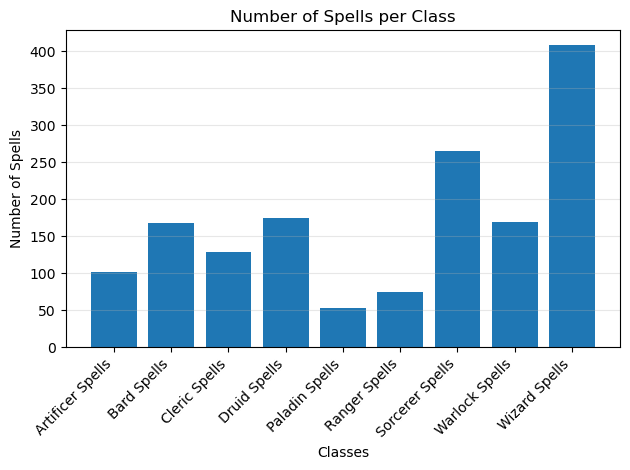

In [118]:
n_spells = []
for classes in class_spell_group:
    n =  len(class_spell_group[classes])
    n_spells.append(n)
    print(classes, "- Number of Spells:", n)

plt.grid(alpha=0.3, axis='y')
plt.bar(class_spell_group.keys(), n_spells)
plt.xlabel("Classes")
plt.ylabel("Number of Spells")
plt.title("Number of Spells per Class")
plt.xticks(rotation=45, ha="right") 
plt.tight_layout() 
plt.show()

In [119]:
spell_to_classes = defaultdict(list)
class_to_spells = defaultdict(list)

for classes, spells in class_spell_group.items():
    for spell in spells:
        spell_to_classes[spell].append(classes)

spells_by_class = {spell: classes for spell, classes in spell_to_classes.items()}
spells_in_multiple_classes = {spell: classes for spell, classes in spell_to_classes.items() if len(classes) > 1}

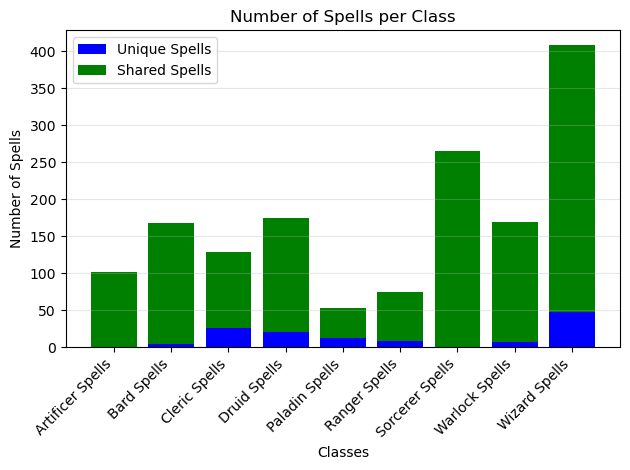

In [120]:
shared_spell_counts = defaultdict(int)

for spell, classes in spells_in_multiple_classes.items():
    for class_name in classes:
        shared_spell_counts[class_name] += 1

classes = list(shared_spell_counts.keys())
shared_counts = list(shared_spell_counts.values())

classes, shared_counts = zip(*sorted(zip(classes, shared_counts)))

total_counts = [len(class_spell_group[class_name]) for class_name in class_spell_group.keys()]
shared_counts = [shared_spell_counts.get(class_name, 0) for class_name in class_spell_group.keys()]
unique_counts = [total - shared for total, shared in zip(total_counts, shared_counts)]

plt.grid(alpha=0.3, axis='y')
plt.bar(class_spell_group.keys(), unique_counts, color='blue', label='Unique Spells')
plt.bar(class_spell_group.keys(), shared_counts, bottom=unique_counts, color='green', label='Shared Spells')
plt.xlabel("Classes")
plt.ylabel("Number of Spells")
plt.title("Number of Spells per Class")
plt.xticks(rotation=45, ha="right")
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Oh and for any DND buffs. I'm counting "Cantrips" as spells. I'm not messing about with the whole *"Well they're not **Technically** spells"*, they are and I won't hear otherwise.

In [252]:
for n_classes in range(len(class_spell_group.keys()),1,-1):    
    shared_spells = {spell: classes for spell, classes in spells_in_multiple_classes.items() if len(classes) == n_classes}

    print(f"\nNumber of spells shared amongst {n_classes} classes: {len(shared_spells)}")
    print(f"Spell(s) shared amongst ({n_classes} classes):")
    for spell, classes in shared_spells.items():
        print(f"{spell}: {', '.join(classes)}")


Number of spells shared amongst 9 classes: 0
Spell(s) shared amongst (9 classes):

Number of spells shared amongst 8 classes: 2
Spell(s) shared amongst (8 classes):
Detect Magic: Artificer Spells, Bard Spells, Cleric Spells, Druid Spells, Paladin Spells, Ranger Spells, Sorcerer Spells, Wizard Spells
Dispel Magic: Artificer Spells, Bard Spells, Cleric Spells, Druid Spells, Paladin Spells, Sorcerer Spells, Warlock Spells, Wizard Spells

Number of spells shared amongst 7 classes: 1
Spell(s) shared amongst (7 classes):
Enhance Ability: Artificer Spells, Bard Spells, Cleric Spells, Druid Spells, Ranger Spells, Sorcerer Spells, Wizard Spells

Number of spells shared amongst 6 classes: 8
Spell(s) shared amongst (6 classes):
Mending: Artificer Spells, Bard Spells, Cleric Spells, Druid Spells, Sorcerer Spells, Wizard Spells
Thunderclap: Artificer Spells, Bard Spells, Druid Spells, Sorcerer Spells, Warlock Spells, Wizard Spells
Cure Wounds: Artificer Spells, Bard Spells, Cleric Spells, Druid Sp